## Start the Docker container

### Run the following commands:
docker run -it --rm -p 8888:8888 -v /Users/sylvain/Data_Science/Kaggle/competition_titanic/datasets:/home/jovyan/datasets jupyter-server

In [271]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib as plt

<h3>Data preprocessing

In [272]:
def cleanData(df):
    
    # Replace the value of the missing "Embarked" by "S" (the most common)
    df.loc[df.loc[:,"Embarked"].isna(), "Embarked"] = df.loc[df.loc[:,"Embarked"].isna(), "Embarked"].apply(lambda x: "S")
    # Replace the missing pclass value with the most common one
    df.loc[df.loc[:,"Pclass"].isna(), "Pclass"] = df.loc[df.loc[:,"Pclass"].isna(), "Pclass"].apply(lambda x: 3)
    # Replace the missing Fare values with the mean one
    df.loc[df.loc[:,"Fare"].isna(), "Fare"] = df.loc[df.loc[:,"Fare"].isna(), "Fare"].apply(lambda x:df.loc[:,"Fare"].mean())
    # fill the missing age values
    df.loc[df.loc[:,"Age"].isna(), "Age"] = df.loc[df.loc[:,"Age"].isna(), "Age"].apply(lambda x: df.loc[:,"Age"].mean())
    # df = guessAge(df=df)
    
    # drop Name, Ticket and Cabin
    df.drop(
        labels=["Name", "Ticket", "Cabin"],
        inplace=True,
        axis=1
        ) 

    # replace Sex and Embarked with dummy variables
    df = pd.get_dummies(data=df)
    
    return df

In [273]:
def scaleData(df=pd.DataFrame):
	'''
 	This function will scale the columns of the data Frame which are not binary and return it
  	'''
	columnsName = df.columns
	indexName = df.index
	scaler = StandardScaler()
	scaledColumns = pd.DataFrame(scaler.fit_transform(X=df.loc[:, ["Age", "Fare"]]), columns=["Age", "Fare"], index=indexName)
	
	return df

In [274]:
def featureEngineering_1(df:pd.DataFrame):
    
	# define the helper functions
	def isClassMember(x, classTicket):
		if x == classTicket:
			return 1
		return 0

	def singleOrCouple(x):
		if x>0:
			return 1
		return 0

	def oneOrMore(x):
		if x>0:
			return 1
		return 0

	# encode the new features
	df["siblings"] = df.loc[:,"SibSp"].apply(lambda x: oneOrMore(x))
	df["couple"] = df.loc[:,"Parch"].apply(lambda x:singleOrCouple(x))
	df["firstClass"] = df.loc[:,"Pclass"].apply(lambda x:isClassMember(x, 1))
	df["secondClass"] = df.loc[:,"Pclass"].apply(lambda x:isClassMember(x, 2))
	df["thirdClass"] = df.loc[:,"Pclass"].apply(lambda x:isClassMember(x, 3))
	
	# drop the old ones
	df = df.drop(labels=["Pclass", "SibSp", "Parch"], axis=1)
 
	return df

In [275]:
def binAge(df:pd.DataFrame):
	age_bin = pd.cut(
		x=df.loc[:,"Age"],
		bins=[0,16,35,55,120],
		labels=False
	)

	def ageCategory(x:int, age:int):
		if x == age:
			return 1
		return 0

	df["kid"] = age_bin.apply(lambda x:ageCategory(x,0))
	df["young_adult"] = age_bin.apply(lambda x:ageCategory(x,1))
	df["mature_adult"] = age_bin.apply(lambda x:ageCategory(x,2))
	df["senior"] = age_bin.apply(lambda x:ageCategory(x,3))
	df.drop(labels=["Age"], axis=1, inplace=True)
 
	return df

In [276]:
def binFare(df:pd.DataFrame):
	df["low_fare"] = df.loc[:,"Fare"].apply(lambda x: 1 if x<20 else 0)
	df["medium_fare"] = df.loc[:,"Fare"].apply(lambda x: 1 if 20<=x<80 else 0)
	df["high_fare"] = df.loc[:,"Fare"].apply(lambda x: 1 if 80<=x else 0)
	df.drop(labels=["Fare"], axis=1, inplace=True)
 
	return df

In [277]:
def dfPipeline(df:pd.DataFrame):
	df = cleanData(df)
	df = featureEngineering_1(df)
	df = binAge(df)
	df = binFare(df)
	# df = scaleData(df)
	return df

### Preprocess the data and save the results

In [285]:
# Train dataset
df_train = pd.read_csv(
	filepath_or_buffer="datasets/train.csv",
 index_col=0
)

df_train = dfPipeline(df_train)

df_train.to_csv(path_or_buf="datasets/train_clean.csv")

# Test dataset
df_test = pd.read_csv(
	filepath_or_buffer="datasets/test.csv",
 index_col=0
)
df_test = dfPipeline(df_test)

df_test.to_csv(path_or_buf="datasets/test_clean.csv")

In [279]:
# Clean and scale the data
df = dfPipeline(df)
# create the features and target datasets
features = df.copy()
features.drop(labels="Survived", axis=1, inplace=True)
target = df.loc[:,"Survived"].copy()
# create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [280]:
df.head()

,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,siblings,couple,firstClass,secondClass,thirdClass,kid,young_adult,mature_adult,senior,low_fare,medium_fare,high_fare
PassengerId,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0
2,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0
4,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0
5,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0


### Neural network

The best validation accuray is = 0.878923773765564
The mean validation accuray is = 0.8766816258430481
The mean accuray is = 0.8506172835826874


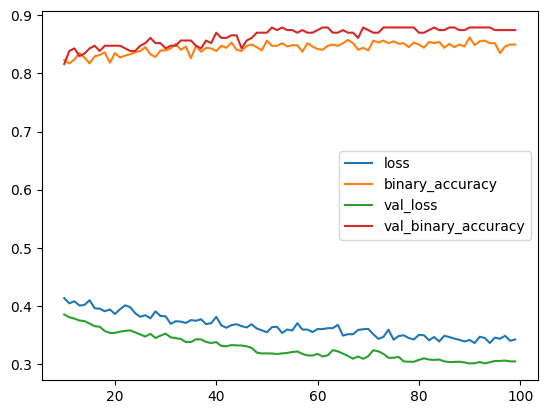

In [281]:
INPUT_SHAPE = [len(x_train.columns)]
X=features
Y=target
# x=x_train
# y=y_train

model = keras.Sequential([
	layers.Dense(units = 256, input_shape = INPUT_SHAPE, activation="relu"),
	# layers.BatchNormalization(),
	layers.Dropout(0.3),
 	layers.Dense(units = 512, activation="relu"),
	# layers.BatchNormalization(),
	layers.Dropout(0.3),
  	layers.Dense(units = 256, activation="relu"),
	# layers.BatchNormalization(),
	layers.Dropout(0.3),
	layers.Dense(units = 1, activation = "sigmoid")
])

model.compile(
	optimizer="adam",
	loss="binary_crossentropy",
	metrics=["binary_accuracy"],
)

early_stopping = EarlyStopping(
	patience = 50,
 	min_delta = 0.01,
	restore_best_weights = True,
)

# train the model
training_history = model.fit(
	x=X,
	y=Y,
	validation_data = (
		x_test,
		y_test,
	),
	batch_size = 256,
	epochs = 100,
 	callbacks = [early_stopping],
	verbose = False,
)

# see the training history
history_df = pd.DataFrame(training_history.history)
history_df.loc[10:,:].plot()
best_val_acc = history_df.loc[:,"val_binary_accuracy"].max()
print(f"The best validation accuray is = {best_val_acc}")
mean_val_acc = history_df.iloc[-10:,3].mean()
print(f"The mean validation accuray is = {mean_val_acc}")
mean_val_acc = history_df.iloc[-10:,1].mean()
print(f"The mean accuray is = {mean_val_acc}")

In [282]:
'''
The best validation accuray is = 0.878923773765564
The mean validation accuray is = 0.8739910423755646
The mean accuray is = 0.8562289535999298
'''

'\nThe best validation accuray is = 0.878923773765564\nThe mean validation accuray is = 0.8739910423755646\nThe mean accuray is = 0.8562289535999298\n'

<h3>Make a prediction for the competition</h3>

In [283]:
# Load the Dataset
df = pd.read_csv(filepath_or_buffer="datasets/test.csv", index_col=0)

# Save the index
resDic = {"PassengerId": df.index}

# Clean and scale the data
df = dfPipeline(df)

# make the prediction
temp = model.predict(df)
pred = []
for arr in temp:
    pred.append(arr[0])
resDic["Survived"] = pred

# save it in a DataFrame
prediction = pd.DataFrame(data=resDic)

# make the prediction an integer
prediction.loc[:,"Survived"] = prediction.loc[:,"Survived"].apply(lambda x:round(x))

# save the prediction
prediction.to_csv(path_or_buf="datasets/predictionNN_feat_eng.csv", index=False)

14/14 [==============================] - 0s 768us/step


/var/folders/sg/d2yjkd7s22zcny48m8_01qpm0000gn/T/ipykernel_17720/3825112789.py:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  prediction.loc[:,"Survived"] = prediction.loc[:,"Survived"].apply(lambda x:round(x))
